In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


In [19]:

# Load data
data = pd.read_csv('hiv_dataset.txt', delimiter='\t')
print(data.tail())

       SeqID   FPV    ATV   IDV    LPV    NFV   SQV   TPV  DRV P1  ... P91  \
2390  615536  13.0   32.0   8.5   16.0    8.7   4.1  10.0  9.0  -  ...   -   
2391   54179  24.8    NaN   8.6   37.5    3.0   2.0   NaN  NaN  -  ...   -   
2392   61441   NaN    8.6   NaN    0.3    NaN   NaN   NaN  NaN  -  ...   -   
2393  148039   2.5   16.0   7.0    3.6   63.0  11.0   3.2  1.5  -  ...   -   
2394  117071  12.0  100.0  36.0  100.0  100.0  50.0   1.3  3.0  -  ...   -   

     P92 P93 P94 P95 P96 P97 P98 P99  \
2390   -   -   -   -   -   -   -   -   
2391   -   -   -   -   -   -   -   -   
2392   -   L   -   -   -   -   -   -   
2393   -   L   -   -   -   -   -   -   
2394   -   L   -   -   -   -   -   -   

                                            CompMutList  
2390  L10I, I13IV, G16GE, V32I, L33F, N37S, M46L, K5...  
2391                             L10I, M46I, L76V, I84V  
2392  T12S, I15V, L19I, M36I, R41K, K45N, I50L, L63P...  
2393  I13V, K20T, E35N, M36I, N37E, I62V, L63P, K70R...  


In [20]:
# Define a function to preprocess sequence data
def encode_sequence(x):
    if x == '-' or len(x) > 1:
        return 0
    else:
        return ord(x) - ord('A') + 1  # offset by 1 to differentiate 'A' from '-'

sequence_data = data.filter(regex='^P\\d+$').applymap(encode_sequence)


In [21]:
from joblib import dump

# Scale the sequence data
scaler = StandardScaler()
X = sequence_data.values
y = data['FPV'].fillna(0)  # Fill NA values with 0
y = (y > 1).astype(int)  # Binary classification for resistance


In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling on train and test sets separately to prevent data leakage
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for Conv1D (batch, steps, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [23]:
# Define the model architecture with Batch Normalization and Dropout
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 97, 64)            256       
                                                                 
 batch_normalization_2 (Batc  (None, 97, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 48, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 128)           24704     
                                                                 
 batch_normalization_3 (Batc  (None, 46, 128)          512       
 hNormalization)                                                 
                                                      

In [24]:
# Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [25]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=64, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
30/30 [==============================] - 3s 43ms/step - loss: 0.6114 - accuracy: 0.7897 - val_loss: 0.5572 - val_accuracy: 0.7891
Epoch 2/50
30/30 [==============================] - 1s 43ms/step - loss: 0.4162 - accuracy: 0.8413 - val_loss: 0.5496 - val_accuracy: 0.7557
Epoch 3/50
30/30 [==============================] - 1s 46ms/step - loss: 0.3691 - accuracy: 0.8554 - val_loss: 0.5462 - val_accuracy: 0.7557
Epoch 4/50
30/30 [==============================] - 1s 43ms/step - loss: 0.3490 - accuracy: 0.8643 - val_loss: 0.5905 - val_accuracy: 0.7599
Epoch 5/50
30/30 [==============================] - 1s 47ms/step - loss: 0.3027 - accuracy: 0.8706 - val_loss: 0.6715 - val_accuracy: 0.7557
Epoch 6/50
30/30 [==============================] - 1s 41ms/step - loss: 0.2881 - accuracy: 0.8810 - val_loss: 0.6654 - val_accuracy: 0.7662
Epoch 7/50
30/30 [==============================] - 1s 44ms/step - loss: 0.2879 - accuracy: 0.8841 - val_loss: 0.5894 - val_accuracy: 0.7996
Epoch 8/50
30

In [26]:
# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_binary))
print(confusion_matrix(y_test, y_pred_binary))

15/15 [==============================] - 0s 5ms/step - loss: 0.5424 - accuracy: 0.8267
Test Accuracy: 82.67%
15/15 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       203
           1       0.90      0.79      0.84       276

    accuracy                           0.83       479
   macro avg       0.83      0.83      0.83       479
weighted avg       0.84      0.83      0.83       479

[[179  24]
 [ 59 217]]


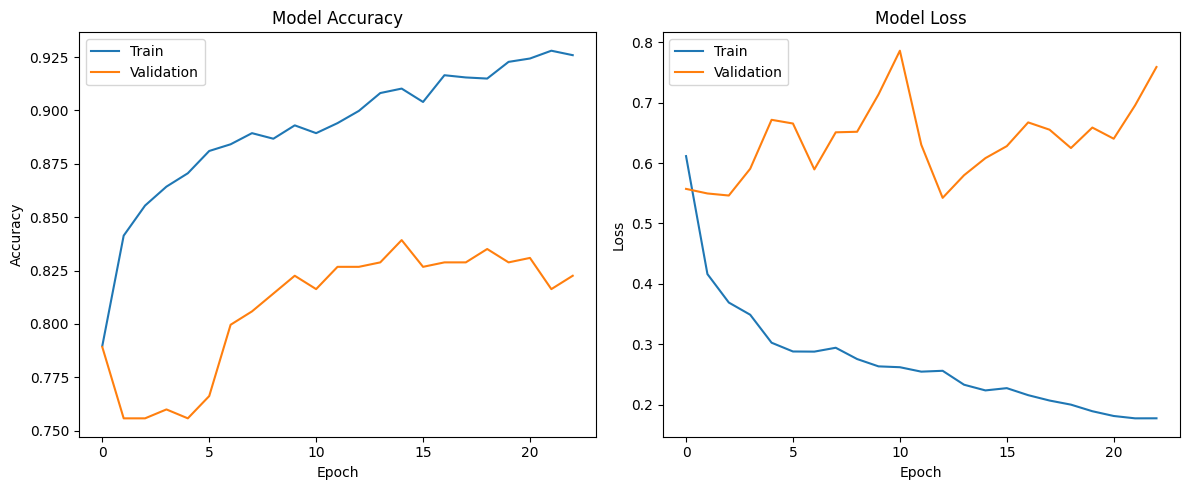

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()